In [34]:
# ******************************
# *** INCLUDES AND FUNCTION DEFS
# ******************************
import numpy as np
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact
import h5py
import os
import datetime
import xml.etree.ElementTree as ET
from tifffile import imsave
from tifffile import imread
from scipy.signal import butter, filtfilt

# $$$$ Conversion/Data Container Related Functions

def hdfToTiff(path,hdfDataSet):
    imsave(path,np.swapaxes(np.swapaxes(hdfDataSet,0,2),1,2))
    
def convertResFrame(rawFrameChunk,linePx,tLines,sampPerPx):
    
    fullResLinePx=int(linePx*sampPerPx*2)
    resLines=int(tLines*0.5)
    halfResLinePx=int(linePx*sampPerPx)
    cFr=np.reshape(rawFrameChunk,(resLines,fullResLinePx))
    cFr=np.reshape(cFr,(tLines,int(linePx*sampPerPx)))
    cFr[0:halfResLinePx:2,:]=np.fliplr(cFr[0:halfResLinePx:2,:])

    return cFr

def convertNormFrame(rawFrameChunk,linePx,tLines,biDi):
    linePx=int(linePx)
    lineCnt=int(tLines)
    cFr=np.reshape(rawFrameChunk,(lineCnt,linePx))
    if biDi==1:
        cFr[0:linePx:2,:]=np.fliplr(cFr[0:linePx:2,:])
        
    return cFr

def convertGalvoFrame(rawFrameChunk,linePx,tLines,biDi):
    linePx=int(linePx)
    lineCnt=int(tLines)
    cFr=np.reshape(rawFrameChunk,(lineCnt,linePx))
    if biDi==1:
        cFr[0:linePx:2,:]=np.fliplr(cFr[0:linePx:2,:])
        
    return cFr

# Metadata Functions
def getXMLPositions(tree):
    xRoot=tree.getroot()
    mainXRef=xRoot[1][26].findall('./SubindexedValues')
    gg=xRoot.findall('Sequence')

    aaa=[]
    # go through all sequences and find all elements that have positions
    for n in range(0,len(gg)):
        tAAA=[mainXRef,gg[0].findall('.//SubindexedValues')]
        tAAA =[x for y in tAAA for x in y]
        aaa.append(tAAA)
    # flatten this list
    aaa = [x for y in aaa for x in y]


    strList=[]
    valList=[]
    for n in range(0,len(aaa)):
        # first see how many x,y,z values were logged.
        # there can be multiple z-devices
        tIndCount=len(aaa[n].findall('./'))
        for p in range(0,tIndCount):
            strList.append(aaa[n].attrib['index'] + '_{}'.format(p))
            valList.append(float(aaa[n][p].attrib['value']))
    posSet=set(strList)
    posCount=len(posSet)
    countsPerPos=int(len(valList)/posCount)
    posArray=np.zeros((posCount,countsPerPos))

    sortCounter=0
    appendCounter=0
    for n in range (0,len(strList)):

        # First we want to add to a value serially to an ambiguous number
        # of 'channels.' So we need to reset a counter when we go 
        # over the number of channels. Then we increment the index 
        # across the channels. 

        if sortCounter>=posCount:
            sortCounter=0
            appendCounter=appendCounter+1
        posArray[sortCounter,appendCounter]=valList[n]
        sortCounter=sortCounter+1
    return posArray, posSet

def getXMLTime(tree):
    xRoot=tree.getroot()
    cyclesStart=2
    relTime=[]
    absTime=[]
    cycleNums=len(xRoot)-cyclesStart
    for n in range(0,cycleNums):
        gg=xRoot[cyclesStart+n].findall('Frame')
        for x in range(0,len(gg)):
            relTime.append(float(gg[x].attrib['absoluteTime']))
            absTime.append(float(gg[x].attrib['relativeTime']))
    return relTime, absTime, cycleNums 

def parseGalvoXML(tree):
    xRoot=tree.getroot()
    sMeta={}
    sMeta['scanType']=xRoot[1][0].attrib['value']

    sMeta['bitDepth']=int(xRoot[1][1].attrib['value'])
    sMeta['dwellTime']=float(xRoot[1][4].attrib['value'])
    sMeta['frameTime']=float(xRoot[1][5].attrib['value'])
    sMeta['pockelsVal']=float(xRoot[1][11][0].attrib['value'])
    sMeta['lineCount']=int(xRoot[1][12].attrib['value'])
    sMeta['pixelsPerLine']=int(xRoot[1][20].attrib['value'])
    sMeta['frameAvg']=int(xRoot[1][25].attrib['value'])

    sMeta['pmt_1_val']=float(xRoot[1][21][0].attrib['value'])
    sMeta['pmt_2_val']=float(xRoot[1][21][1].attrib['value'])
    sMeta['pmt_3_val']=float(xRoot[1][21][2].attrib['value'])
    sMeta['pmt_4_val']=float(xRoot[1][21][3].attrib['value'])

    sMeta['pos_X']=float(xRoot[1][22][0][0].attrib['value'])
    sMeta['pos_Y']=float(xRoot[1][22][1][0].attrib['value'])
    sMeta['pos_Z']=float(xRoot[1][22][2][0].attrib['value'])
    sMeta['linePeriod']=float(xRoot[1][27].attrib['value'])
    sMeta['zDevice']=xRoot[1][33].attrib['value']
    sMeta['multSamp']=1
    
    return sMeta

def parseResoXML(tree):
    xRoot=tree.getroot()
    sMeta={}
    # The date is in the root as part of a date/time string.
    sMeta['labDate']=xRoot.attrib['date'][0:10]
    scanDate=xRoot.attrib['date'][0:10]
    tSP=""
    for x in range(0,len(scanDate.split('/'))):
        tSP=tSP+scanDate.split('/')[x]
    scanDate=int(tSP)
    sMeta['scanDate']=scanDate
    sMeta['scanType']=xRoot[1][0].attrib['value']

    sMeta['bitDepth']=int(xRoot[1][1].attrib['value'])
    sMeta['dwellTime']=float(xRoot[1][4].attrib['value'])
    sMeta['frameTime']=float(xRoot[1][5].attrib['value'])
    sMeta['pockelsVal']=float(xRoot[1][11][0].attrib['value'])
    sMeta['lineCount']=int(xRoot[1][12].attrib['value'])
    sMeta['pixelsPerLine']=int(xRoot[1][20].attrib['value'])
    sMeta['frameAvg']=int(xRoot[1][25].attrib['value'])

    sMeta['pmt_1_val']=float(xRoot[1][21][0].attrib['value'])
    sMeta['pmt_2_val']=float(xRoot[1][21][1].attrib['value'])
    sMeta['pmt_3_val']=float(xRoot[1][21][2].attrib['value'])
    sMeta['pmt_4_val']=float(xRoot[1][21][3].attrib['value'])

    sMeta['pos_X']=float(xRoot[1][22][0][0].attrib['value'])
    sMeta['pos_Y']=float(xRoot[1][22][1][0].attrib['value'])
    sMeta['pos_Z']=float(xRoot[1][22][2][0].attrib['value'])
    sMeta['linePeriod']=float(xRoot[1][27].attrib['value'])
    sMeta['zDevice']=xRoot[1][33].attrib['value']
    sMeta['multSamp']=1
    
    return sMeta

def parseCameraXML(tree):
    xRoot=tree.getroot()
    sMeta={}
    # The date is in the root as part of a date/time string.
    sMeta['scanType']=xRoot[1][0].attrib['value']
    sMeta['exposureTime']=int(xRoot[1][4].attrib['value'])
    sMeta['bitDepth']=int(xRoot[1][1].attrib['value'])
    sMeta['binFactor']=int(xRoot[1][2].attrib['value'])
    sMeta['gain']=int(xRoot[1][5][0].attrib['value'])
    sMeta['frameTime']=float(xRoot[1][9].attrib['value'])
    sMeta['lineCount']=int(xRoot[1][16].attrib['value'])
    sMeta['pixelsPerLine']=int(xRoot[1][24].attrib['value'])

    sMeta['pos_X']=float(xRoot[1][26][0][0].attrib['value'])
    sMeta['pos_Y']=float(xRoot[1][26][1][0].attrib['value'])
    sMeta['pos_Z']=float(xRoot[1][26][2][0].attrib['value'])
    sMeta['zDevice']=xRoot[1][37].attrib['value']
    sMeta['multSamp']=1
    
    return sMeta

# Image Analysis Functions
    
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [29]:
# ******************************
# Batch Decode Raw
# ******************************

# Set a subject ID, path to save TIFs or HDFs and path to the data.
subID="ci03"
savePath='/Users/cad/Desktop/rawtest/'
basePath='/Users/cad/Desktop/rawtest/'

# Let's catalog the base path and determine
# which folders have single images, t-series, z-series etc.
# Each need to be handled differently.

parentDir=sorted(os.listdir(basePath))
print(parentDir)
sIDs=[]
tIDs=[]
zIDs=[]


cTime = datetime.datetime.now()
convertDate=cTime.strftime("%m%d%Y")
    

xmlz=[]
for n in range(0,len(parentDir)):
    j=os.listdir(basePath+parentDir[n])
    tXML=sorted([x for x in j if 'xml' in x])
    try:
        xmlz.append(tXML[0])
    except:
        xmlz.append([])

['ccdMap_ci03-001', 'ccdMap_ci04-001']


In [30]:
xmlz[0]

'ccdMap_ci03-001.xml'

In [35]:
# This is how we would deal with a single directory/experiment.
# We can loop through them all if we want, as we cataloged all we need above.

# Here cL is the current folder we are converting.
# We will get the location of cL's xml and data.
cL=0
xmlPath=basePath + parentDir[cL] + "/" + xmlz[cL]
dataPath=basePath + parentDir[cL] + "/"
dataSet=parentDir[cL]

# Parse the xml for this experiment by making a tree object.
# We make a root object just to see what experiment type we have,
# the meta data is parsed differently between camera and laser 
# scanning experiments due to differences in entries. 
# But, from then on we will pass the xml tree object we make
# as an argument to functions that will give us a dict 'scanMeta'
# that contains the meta-data we care about. 

tree = ET.parse(basePath + parentDir[cL] + "/" + xmlz[cL])
xRoot=tree.getroot()

# Check to see if this is:
# a) a laser scanning image
# b) a camera picture
# The xml file is slightly different between the two.
scanType=xRoot[1][0].attrib['value']
if scanType=='Camera':
    scanMeta=parseCameraXML(tree)

elif scanType=='Galvo':
    scanMeta=parseGalvoXML(tree)
    
elif scanType=='ResonantGalvo':
    scanMeta=parseResoXML(tree)

pixelsPerFrame=int(scanMeta['pixelsPerLine']*scanMeta['lineCount']*scanMeta['multSamp'])

# Get time vectors from Bruker XML
# rel time is relative to first frame
# abs time is relative to the PFI0 trigger
# I will save abs time for you as a dataset in the HDF5 file by default. 
[bTime_rel,bTime_abs,bCycles]=getXMLTime(tree)
if scanMeta['zDevice']==1:
    [stagePositions,axisLabels]=getXMLPositions(tree)

In [45]:
# Now we deal the with the image data.
# We need to look in the directory and see what raw files we have.
# Bruker appends CYCLE in all raw files, so we can filter on that.
rawDir=os.listdir(dataPath)
rawFiles=sorted([x for x in rawDir if 'CYCLE' in x])

# We initialize some lists so we can append.
#
# Bruker writes to a binary file til' it reaches 2.1 GB or so, then 
# they start writing to another. In the end, they pad the data a bit, 
# so you will almost always end up with unused bits. So, we have to 
# query all the raw chunks and determine how many frames we can make. 

framesInChunks=[]
pxSizes=[]
rdc=np.array([])

# Here is how I catalog the raw chunks.
# I memory map the binaries as 16-bit unsigned ints (*).
# I then round down the result of all unit16 points and the pixels per frame
# to the nearest int. The padded data is always at the end, so you can decode 
# from data point 0 on to this end-stop we calculate.

# You can read the data into memory if you must here by using
# np.fromfile instead of memmap. We decode the data in a different step
# so it is silly to actually read in the data here, especially if you have a ton.

# There is an offset we need to calculate.
# I need the min/max of the data. Which is across chunks.
tMins=[]
tMaxs=[]
numChan=1

allCounts=[]
# count first
for n in range(0,len(rawFiles)):
    curFile=dataPath+rawFiles[n]
    tAr=np.memmap(curFile, dtype="uint16")
    allCounts.append(len(tAr))
    tMins.append(np.amin(tAr))
    tMaxs.append(np.amax(tAr))
    tAr=[]

dSum=np.sum(allCounts)

# Now we can make a large memory map across the files:
curFile=dataPath+rawFiles[0]
tAr=np.memmap(curFile, dtype="uint16",shape=(dSum,))
curPoint=allCounts[0]
for n in range(1,len(rawFiles)):
    curFile=dataPath+rawFiles[n]
    gHJ=np.memmap(curFile, dtype="uint16")
    tAr[curPoint:curPoint+allCounts[n],]=gHJ
    curPoint=curPoint+allCounts[n]
    gHJ=[]
    
tsZ=int(tAr.size)
framesInChunks.append(int(tsZ/pixelsPerFrame))
pxSizes.append(tsZ)

actualFrameCount=len(bTime_abs)*numChan
totalFrames=int(np.sum(pxSizes)/pixelsPerFrame)
bAr=np.zeros(int(np.sum(pxSizes)),dtype='uint16')

lastStrt=0
curSz=0

# (*):    
# Bruker uses a general dynamics or NI-611X board to digitize data.
# These are 13 and 12 bit boards, respectivley. 
# Because they want to give users a rational tif file, 
# they store data as uint16 knowing they can't use the other bits.
# 16 bit tiffs have wide-support, 8 kills data. 

In [46]:
print(totalFrames)
print(actualFrameCount)
scanMeta['lineCount']
504/168

27738
27738


3.0

In [47]:
# resonant data (at least) has an offset camera frames don't
if scanType != 'Camera':
    bitMax=(2**scanMeta['bitDepth'])
    bitMax=bitMax-1
    rawMin=int(np.amin(tMins))
    # I don't use max but could to log dynamic range if we want.
    rawMax=int(np.amax(tMaxs))
    zPt=bitMax-rawMin
    offs=bitMax-zPt
elif scanType == 'Camera':
    offs=0

cIM=0
framAr=np.zeros((scanMeta['lineCount'],scanMeta['pixelsPerLine'],actualFrameCount),dtype='uint16')
lnPx=scanMeta['lineCount']*scanMeta['pixelsPerLine']*scanMeta['multSamp']

numChan=1
           
for z in range(0,actualFrameCount,numChan):
    
    for n in range(0,numChan):
        strInd=(cIM*lnPx*numChan)+n
        endInd=((cIM*lnPx)+lnPx)*numChan+n
        rwDt=tAr[strInd:endInd:numChan]
        
        if scanType=='ResonantGalvo':
            aa=convertResFrame(rwDt,scanMeta['pixelsPerLine'],scanMeta['lineCount'],scanMeta['multSamp'])
            bb=np.reshape(aa,(aa.shape[0],int(aa.shape[1]/scanMeta['multSamp']),scanMeta['multSamp']))
            aa=[]
            rwDt=[]
            framAr[:,:,z+n]=np.mean(bb,axis=2).astype('uint16')-offs
            bb=[]
            
        elif scanType=='Camera':
            aa=convertNormFrame(rwDt,scanMeta['pixelsPerLine'],scanMeta['lineCount'],0)
            framAr[:,:,z+n]=aa-offs
            aa=[]
        elif scanType=='Galvo':
            aa=convertResFrame(rwDt,scanMeta['pixelsPerLine'],scanMeta['lineCount'],1)
            bb=np.reshape(aa,(1024,256,scanMeta['multSamp']))
            aa=[]
            rwDt=[]
            framAr[:,:,z+n]=np.mean(bb,axis=2).astype('uint16')-offs
            bb=[]
            
    cIM=cIM+1
    if np.mod(z,200)==0:
        print('on image: {}'.format(cIM))
print('done')
tAr=[]

on image: 1
on image: 201
on image: 401
on image: 601
on image: 801
on image: 1001
on image: 1201
on image: 1401
on image: 1601
on image: 1801
on image: 2001
on image: 2201
on image: 2401
on image: 2601
on image: 2801
on image: 3001
on image: 3201
on image: 3401
on image: 3601
on image: 3801
on image: 4001
on image: 4201
on image: 4401
on image: 4601
on image: 4801
on image: 5001
on image: 5201
on image: 5401
on image: 5601
on image: 5801
on image: 6001
on image: 6201
on image: 6401
on image: 6601
on image: 6801
on image: 7001
on image: 7201
on image: 7401
on image: 7601
on image: 7801
on image: 8001
on image: 8201
on image: 8401
on image: 8601
on image: 8801
on image: 9001
on image: 9201
on image: 9401
on image: 9601
on image: 9801
on image: 10001
on image: 10201
on image: 10401
on image: 10601
on image: 10801
on image: 11001
on image: 11201
on image: 11401
on image: 11601
on image: 11801
on image: 12001
on image: 12201
on image: 12401
on image: 12601
on image: 12801
on image: 13001
o

<IPython.core.display.Javascript object>


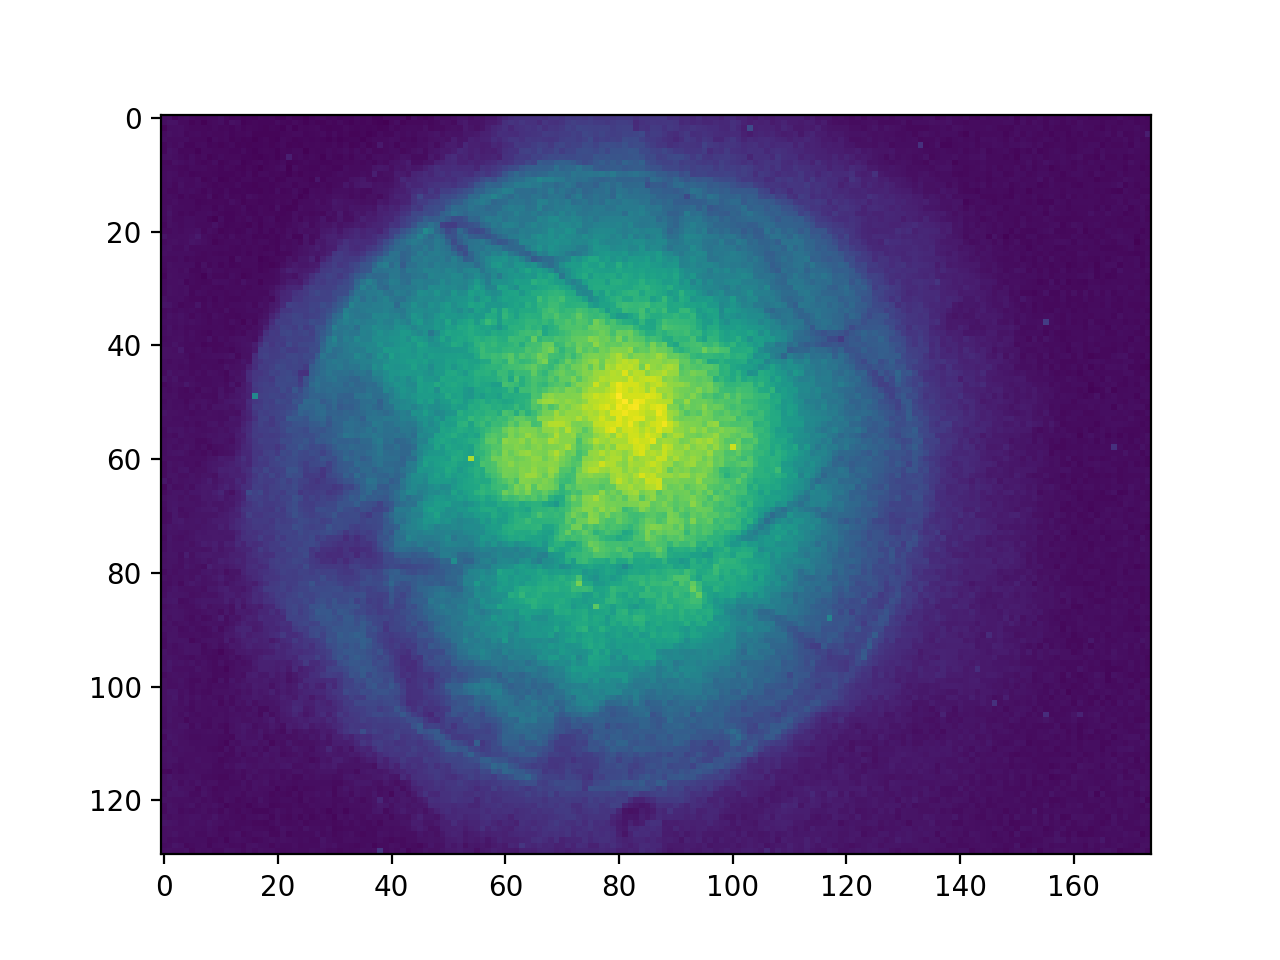

In [48]:
plt.figure(1)
plt.imshow(framAr[:,:,399],aspect='equal')

In [50]:
f = h5py.File(savePath+"{}_{}.hdf".format(subID,'001'), "a")

f[dataSet+"_images"]=framAr
f[dataSet+"_absTime"]=bTime_abs
f[dataSet+"_relTime"]=bTime_rel
if scanMeta['zDevice']==1:
    f[dataSet+"_stagePos"]=stagePositions
f.close()
framAr=[]
print("finished {} of {}".format(cL+1,len(allSubPaths)))

finished 1 of 0


Basic Inspection .... 

In [86]:


# now, let's reopen the hdf and look at frames.

scanDate='001'
try:
    f = h5py.File(savePath+"{}_{}.hdf".format(subID,scanDate), "a")
except:
    print('hdf open')
# datasetNames = [n for n in f.keys()]
sLabs=sorted([x for x in f.keys() if 'stagePos' in x])
tLabs=sorted([x for x in f.keys() if 'Time' in x])


print(sLabs)
print(tLabs)

['tSeries_004_stagePos']
['tSeries_004_absTime']


In [84]:
# make a string for axes labels we will make that a stage attribute
axisString=''
labCount=0
for x in axisLabels:
    labCount=labCount+1

strCnt=0
for x in axisLabels:
    if strCnt<labCount-1:
        axisString=axisString+x+','
    elif strCnt>=labCount-1:
        axisString=axisString+x
    strCnt=strCnt+1
axisString

'XAxis_0,YAxis_0,ZAxis_1,ZAxis_0'

In [87]:
f[sLabs[0]].attrs["axes"]=axisString
f.close()

In [7]:
# now, let's reopen the hdf and look at frames.

scanDate='001'
try:
    f = h5py.File(savePath+"{}_{}.hdf".format(subID,scanDate), "a")
except:
    print('hdf open')
# datasetNames = [n for n in f.keys()]
dLabs=sorted([x for x in f.keys() if 'Time' not in x])
tLabs=sorted([x for x in f.keys() if 'Time' in x])

# ***** Select the non-zeroed indexed run you want to look at
# ***** Also if you want a tif.
dFoc=5
renderTif=0

curData=dLabs[dFoc-1]
curTime=tLabs[dFoc-1]

# If you want a tiff instead.
if renderTif:
    hdfToTiff(savePath+"{}_{}.tif".format(animalName,curData),f[curData])

In [21]:
# now make an image browser function (ipywidgets) and we can scrub.
def browse_images(lowCut=0,highCut=15000):
    n = f[curData].shape[2]
    def view_image(ind):
        Y=aa[:,:,ind]
        plt.figure(50)
        plt.imshow(Y, cmap=plt.cm.gray,aspect='equal',interpolation='bicubic',vmin=lowCut,vmax=highCut)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    interact(view_image, ind=(0,n-1))

In [14]:
f[curData]

<HDF5 dataset "tSeries_005": shape (512, 512, 2000), type "<u2">

In [18]:
aa=f[curData][:,:,:]

In [19]:
plt.imshow(aa[:,:,1])

<IPython.core.display.Javascript object>


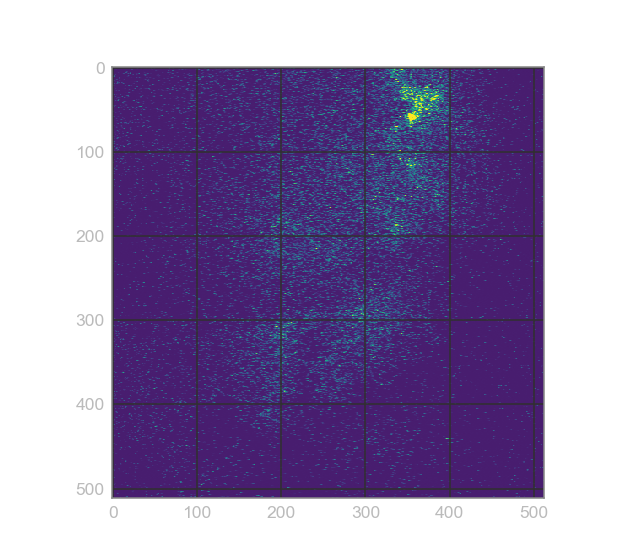

In [17]:
f[curData]
pIm=500
dPlt=f[curData][:,:,pIm]
plt.figure(51)
a=plt.imshow(dPlt,cmap=plt.cm.gray,interpolation='bicubic',aspect='equal',vmin=500,vmax=20000)

<IPython.core.display.Javascript object>


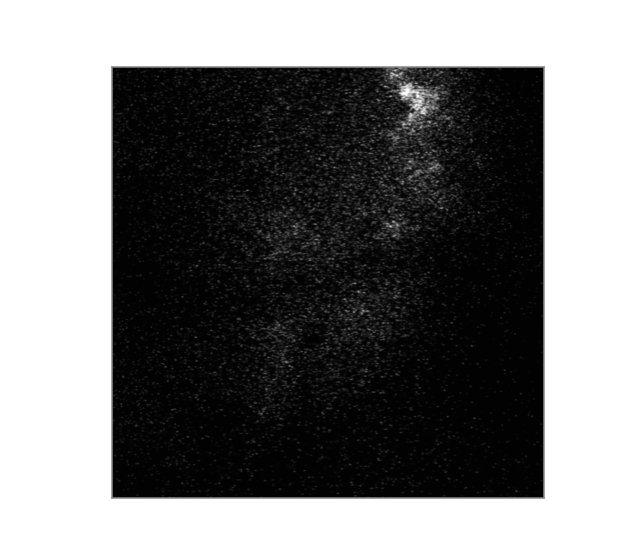

A Jupyter Widget

In [22]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        # %matplotlib inline
plt.figure(50)
browse_images(1000,9000)

In [9]:
# compute the stack's SD across frames. 
# takes a bit, has to map into memory and upsample (sums)
stdDevIm=np.std(f[curData],axis=2)

<IPython.core.display.Javascript object>


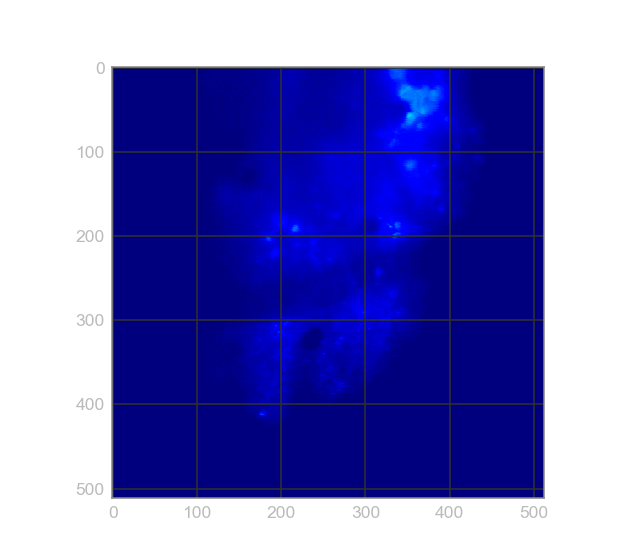

In [12]:
plt.figure(13)
stdPlot=plt.imshow(stdDevIm, cmap=plt.cm.jet,aspect='equal',vmin=500,vmax=7000)

<IPython.core.display.Javascript object>


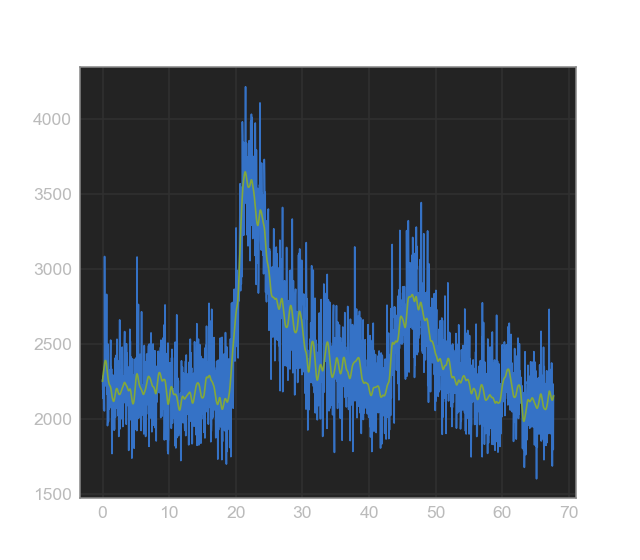

In [13]:
yDim=[187,192]
xDim=[200,220]
roi=f[curData][yDim[0]:yDim[1],xDim[0]:xDim[1],:]
roi=np.reshape(roi,(roi.shape[0]*roi.shape[1],roi.shape[2]))
roiData=np.mean(roi,axis=0)
tt=f[curTime][0:roiData.size]
fData=butter_lowpass_filtfilt(roiData, 1, 1/tt[1],2)


plt.figure(21)
plt.plot(tt,roiData,'b-')
plt.plot(tt,fData,'g-')

In [11]:
f.close()